## 01. Load mgatk variants (and filter if needed)

In [1]:
mgatk_in <- ""#"/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/pre/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/pre.variant.rds"
name <- "d0"
outdir <- ""#"/data2/mito_lineage/Analysis/annotation/output/data/TcellDupi_may17_2021/MTblacklist/"
# Cluster parameters
k.param <- 10

# vars_f <- "filter" #filter, which uses additional filter parameters, or a tsv file where first column is variant names
cells_f <- "all" # all, or a cell tsv file where first column are the cell names
cells_col <- "donor"
cell_id_col <- "ID"
cells_col_val <- 0

# # Additional parameters if either vars or cells are do not have a file associated
# n_cells_conf_detected <- 5
# strand_correlation <- 0.65 
# log10_vmr <- -2 
# mean_coverage <- 20


In [ ]:
SEall <- readRDS("/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/pre/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/pre.signac.rds")

## Subset on cells if given

In [ ]:
if(cells_f != "all"){
    cells <- read_csv(cells_f, sep="\t", id=cell_id_col)
    if(cells_col != ""){
        cells <- cells[, cells_col==cells_col_val]
    }
    SEall <- SEall[,colnames(SEall) %in% rownames(curr_cells)]
}

In [42]:

modify_SEall <- function(se, cells){
    ## Subset cells before calling variants
    se$counts = se$counts[,which(rownames(se$depth) %in% cells)]
    se$depth <- se$depth[which(rownames(se$depth) %in% cells), ]
    return(se)
}

cells <- rownames(SEall$depth)
se <- modify_SEall(SEall, cells)

rowVars <- function(x, ...) {
  Matrix::rowSums((x - Matrix::rowMeans(x, ...))^2, ...)/(dim(x)[2] - 1)
}

se_mean <- (Matrix::rowMeans(se$counts))
se_var <- rowVars(se$counts)
se_vmr <- se_var/(se_mean + 0.00000000001)

$counts
132552 x 200 sparse Matrix of class "dgCMatrix"
                                                                                           
   [1,]   .  .  .  .  .  .   .  .   .   .   .   .   .  .   .  .   .  .   .  .  .   .   .  .
   [2,]   .  .  .  .  .  .   .  .   .   .   .   .   .  .   .  .   .  .   .  .  .   .   .  .
   [3,]   .  .  .  .  .  .   .  .   .   .   .   .   .  .   .  .   .  .   .  .  .   .   .  .
   [4,]   .  .  .  .  .  .   .  .   .   .   .   .   .  .   .  .   .  .   .  .  .   .   .  .
   [5,]   .  .  .  .  .  .   .  .   .   .   .   .   .  .   .  .   .  .   .  .  .   .   .  .
   [6,]   .  .  .  .  .  .   .  .   .   .   .   .   .  .   .  .   .  .   .  .  .   .   .  .
   [7,]   .  .  .  .  .  .   .  .   .   .   .   .   .  .   .  .   .  .   .  .  .   .   .  .
   [8,]   .  .  .  .  .  .   .  .   .   .   .   .   .  .   .  .   .  .   .  .  .   .   .  .
   [9,]   .  .  .  .  .  .   .  .   .   .   .   .   .  .   .  .   .  .   .  .  .   .   .  .
  [10,]   .  .  .  .  . 

### Load Libraries

In [4]:
library(data.table)
library(dplyr)
library(SummarizedExperiment)
library(Matrix)
library(BuenColors)

library(future)
plan()
#plan("multiprocess", workers = workers)
options(future.globals.maxSize = 8000 * 1024^2)

library(Seurat)
library(Signac)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeigh

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays




## 02. Cluster using Seurat FindNeighbors (S-NN graph ) and FindClusters (louvain)

In [6]:
getNN <- function(mat_af, k.param = 10){
  set.seed(1)
  rownames(mat_af) <- make.unique(rownames(mat_af))
  obj <- FindNeighbors(mat_af, k.param = k.param, annoy.metric = "cosine")
  obj
}

# Function to use Seurat functions to call mitochondrial cluster clones
seuratSNN_cosineDistance <- function(obj, resolution){
  clusters <- FindClusters(object = obj$snn, resolution = resolution)
  return(as.character(clusters[,1]))
}


In [7]:
plot_af_clusters <- function(afin, cluster_name){
    mdf <- data.frame(cluster_name, t(afin)) %>%
    group_by(cluster_name) %>% dplyr::filter(n() >= 5) %>% summarize_all(.funs = mean)

    melt_df <- reshape2::melt(mdf, id.vars = "cluster_name")

    # This series of arrangements is for aesthetics
    melt_df2 <- melt_df %>% mutate(g5 = value >= 0.05, g1 = value >= 0.01) %>%  group_by(variable) %>%
    mutate(total_g1 = sum(g1)) %>% 
    arrange(desc((g5)), desc((g1))) %>% dplyr::filter(total_g1 >0)

    # More aestetics
    melt_df2$cluster_name <- factor(as.character(melt_df2$cluster_name ), levels = rev(unique( as.character(melt_df2$cluster_name))))
    melt_df2$variable <- factor(as.character(melt_df2$variable ), levels = (unique( as.character(melt_df2$variable))))
    melt_df2$value <- ifelse(melt_df2$value > 0.1, 0.1, melt_df2$value)
    melt_df2$value <- ifelse(melt_df2$value < 0.005, 0, melt_df2$value)
    

    # Visualize heatmap of clustres x variants
    p1 <- ggplot(melt_df2 , aes(x = variable, y = cluster_name, fill = total_g1)) +
    geom_tile() +
    scale_fill_gradientn(colors = jdb_palette("solar_rojos")) +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank()) +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank()) +
    L_border() +
    theme(legend.position = "none")

    ggsave(file.path(outdir, "variants.png"))
    #cowplot::ggsave(p1, file = paste0("../plots/mutations_clones_",what,"_invivo_grid.pdf"), width = 3.2, height = 1.5)
    print(length(unique(melt_df2$variable)))
    print(length(unique(melt_df2$cluster_name)))


    # Visualize heatmap of clustres x variants
    p1 <- ggplot(melt_df2 , aes(x = variable, y = cluster_name, fill = value)) +
    geom_tile() +
    scale_fill_gradientn(colors = jdb_palette("solar_rojos")) +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank()) +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank()) +
    L_border() +
    theme(legend.position = "none")

    #cowplot::ggsave(p1, file = paste0("../plots/mutations_clones_",what,"_invivo_grid.pdf"), width = 3.2, height = 1.5)
    print("Number of variants")
    print(length(unique(melt_df2$variable)))
    print("Number of clusters")
    print(length(unique(melt_df2$cluster_name)))
    
    ggsave(file.path(outdir, "clusters.png"))
    return(melt_df2)
}

In [8]:
run_clones <- function(SE, curr_out, k.param){
    
    afin <- data.matrix(assays(SE)[["allele_frequency"]])
    # Since the PBMCs alone undercalled the mutations, we will examine the mutations called in the PBMCs and CD34s together
    obj <- getNN(t(sqrt(afin)), k.param=k.param)
    clusters <- seuratSNN_cosineDistance(obj, resolution = 3.5) 
    cluster_name <- stringr::str_pad(as.character(clusters), 3, pad = "0")
    table(cluster_name)
    saveRDS(clusters, file.path(curr_out, "clusters.rds"))
    saveRDS(obj, file.path(curr_out, "af.dimRed.rds"))
    cell_clusters <- data.frame(cell=colnames(afin), cluster=cluster_name)
    write.table(cell_clusters, file.path(curr_out, "cell_clusters.tsv"), row.names=F, sep="\t")
    melt_df2 <- plot_af_clusters(afin, cluster_name)
    write.table(melt_df2, file.path(curr_out, "var_clusters.tsv"), row.names=F, sep="\t")
    
}

# Run workflow

In [3]:
SE <- readRDS(mgatk_in)
colnames(SE) <- lapply(colnames(SE), function(x) paste0(x, name))

print("clones w all cells")
curr_SE <- SE #filt_vars(SE, cells_f, vars_f)
run_clones(curr_SE, outdir, k.param=k.param)

## Create variant matrix
Set some filters

In [9]:
# if(((cells_f=="all") | vars_f=="filters")){
# vars_SE <- data.frame(rowData(SE)) %>%  filter(n_cells_conf_detected >= 5 & strand_correlation > 0.65 & log10(vmr) > -2 & mean_coverage >= 20) %>% pull(variant)
# }

# SE <- SE[vars_SE,]
# print(length(vars_SE))

In [10]:
# filt_vars <- function(curr_SE, cells_f,vars_f){
#     if(((cells_f=="all") | vars_f=="filters")){
#     vars_curr_SE <- data.frame(rowData(curr_SE)) %>%  filter(n_cells_conf_detected >= 5 & strand_correlation > 0.65 & log10(vmr) > -2 & mean_coverage >= 20) %>% pull(variant)
#     curr_SE <- curr_SE[vars_curr_SE,]
#     print(length(vars_curr_SE))
#     }

#     return(curr_SE)#list("curr_SE"=curr_SE, "vars_curr_SE"=vars_curr_SE))
# }

[1] "clones w all cells"
[1] 996


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5538
Number of edges: 1588214

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.1810
Number of communities: 73
Elapsed time: 3 seconds


9 singletons identified. 64 final clusters.



[1] 140
[1] 51
[1] "Number of variants"
[1] 140
[1] "Number of clusters"
[1] 51


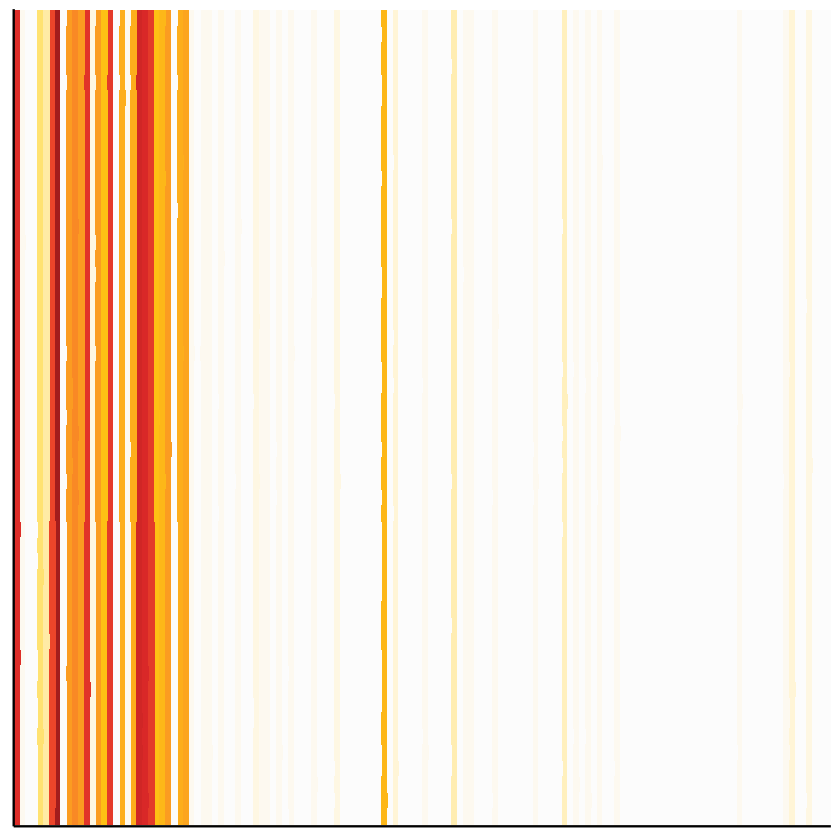

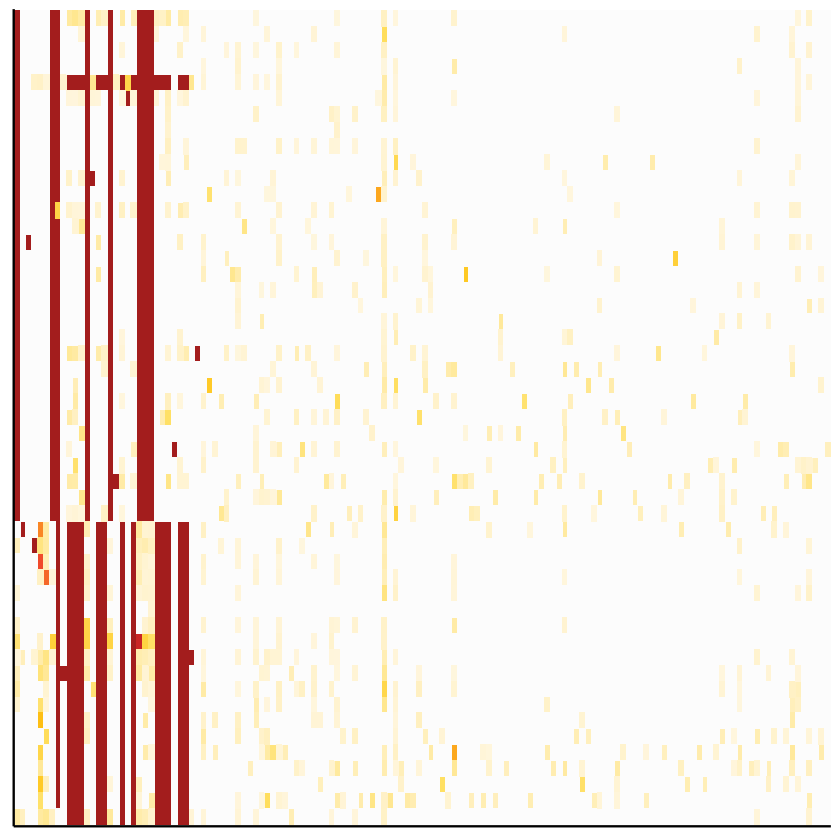

In [11]:
# # Can run either by: 
# # a) running for all cells
# # b) running for all cells that are in the cells file (not all may be in there)
# # c) running across each cell group found in cell_id_col in the cells file (e.g. for each donor)
# if(cells_f != "all"){
#     cells <- read_csv(cells_f, sep="\t", id=cell_id_col)
#     if(cells_col != ""){
#         for (d in cells_col )
#         {
#             print("donor")
#             print(d)
#             curr_cells <- cells[, cells_col==d]
#             curr_SE <- SE[,colnames(SE) %in% rownames(curr_cells)]
#             curr_SE <- filt_vars(curr_SE, cells_f, vars_f)
#             curr_out <- paste0(outdir,d)
#             dir.create(curr_out)
#             run_clones(curr_SE, curr_out)
#         }
#     }else{
#         print("clones w cell filters")
#         run_clones(curr_SE, curr_out)
#         curr_SE <- SE[,colnames(SE) %in% rownames(cells)]
#         curr_SE <- filt_vars(curr_SE, cells_f, vars_f)
#         run_clones(curr_SE, curr_out)
#     }
# }else{
#     print("clones w all cells")
#     curr_SE <- filt_vars(SE, cells_f, vars_f)
#     run_clones(curr_SE, curr_out)
    
# }

## Summarize mean variant AF in each cluster

## Plot the mean for each variant-cluster

## Plot the total cells with the variant in the cluster